<a href="https://colab.research.google.com/github/JunHyeong-data/ML-DL-Study/blob/main/Basic-Deep-Learning/28_%EB%94%A5%EB%9F%AC%EB%8B%9D_segmentation_%ED%8C%8C%EC%9D%B8%ED%8A%9C%EB%8B%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instance Segmentation Fine-tuning (PyTorch)

## 1. 개요

이번 시간에는 **이전 영상에서 배운 인스턴스 세그멘테이션 모델을 파인튜닝**하는 방법을 다룬다.  
인스턴스 세그멘테이션은 **픽셀 단위 분류(pixel-wise classification)** 문제이며,  
기본적으로 **이미지 분류에서 사용하는 Cross Entropy Loss**를 그대로 사용할 수 있다.

이 말은 즉, **복잡한 구조 없이도 간단한 코드로 파인튜닝이 가능하다**는 의미다.

---

## 2. 사용할 모델

PyTorch에서 제공하는 **사전 학습된 세그멘테이션 모델**을 사용한다.

- torchvision은 여러 시멘틱 세그멘테이션 모델 제공
- 그중 성능이 좋은 **DeepLabV3 계열** 사용
- 백본(backbone)은 **MobileNet Large**
  - 비교적 적은 연산량
  - 실습 및 파인튜닝에 적합

```text
DeepLabV3 + MobileNetV3-Large
````

---

## 3. 학습 데이터 (Simulation Dataset)

실습을 위해 실제 데이터셋 대신 **시뮬레이션 데이터**를 사용한다.

### 데이터 생성 방식

* `skimage`에서 제공하는 **random shapes**
* 다양한 도형 생성 (원, 삼각형, 사각형 등)
* 입력 이미지: 여러 도형이 섞인 이미지
* 정답 레이블: **사각형만 1, 나머지는 0 (background)**

즉, 모델은
👉 **“사각형 vs 배경”** 을 구분하는 세그멘테이션 모델로 학습된다.

---

## 4. 파인튜닝 핵심 아이디어

### 🔑 핵심 포인트

> **모델 전체를 바꿀 필요 없이, 가장 마지막 레이어만 수정**

DeepLabV3 구조는 복잡하지만,
우리는 **픽셀 단위 분류만 하면 되므로 마지막 출력 채널만 바꾸면 된다.**

---

## 5. 마지막 레이어 재정의

### 클래스 정의

* 클래스 0: Background
* 클래스 1: Rectangle

총 **2개 클래스**

### Conv2D (1×1) 사용 이유

마지막 레이어는 다음과 같이 정의된다:

```text
Conv2D(kernel_size=1, out_channels=2)
```

#### 왜 커널 사이즈가 1×1인가?

* 입력 텐서: `(H, W, K)`
* 1×1 convolution:

  * 공간 정보(H, W)는 유지
  * **채널(depth)만 변경**
* 결과:

  * `(H, W, 2)` 형태의 출력
  * 각 픽셀마다 클래스별 score 생성

즉,

* 첫 번째 채널 score ↑ → 사각형
* 두 번째 채널 score ↑ → 배경

---

## 6. 1×1 Convolution의 의미

* 공간 정보를 새로 학습하지 않음
* **각 픽셀을 독립적으로 분류**
* 픽셀 단위 Fully Connected Layer와 유사한 역할
* Inception 구조 등에서도 자주 사용됨

👉 **픽셀-wise classification에 최적**

---

## 7. 학습 과정 요약

1. 사전 학습된 DeepLabV3 모델 로드
2. 마지막 Conv2D 레이어를 클래스 수(2)에 맞게 재정의
3. Loss Function: Cross Entropy Loss
4. Optimizer 정의
5. Dataset / Dataloader 구성
6. Fine-tuning 수행

> 실습에서는 학습 시간이 오래 걸리므로
> **미리 학습된 모델을 불러와서 inference 위주로 진행**

---

## 8. 결과

* 여러 랜덤 도형 중 **사각형만 정확히 세그멘테이션**
* 픽셀 단위 분류 기반이므로 구조와 학습이 매우 단순
* 간단한 문제에는 매우 효과적

---

## 9. 한계 및 다음 단계

이 방식은 단순한 문제에는 적합하지만,

* 복잡한 객체
* 다중 클래스
* 실제 환경 데이터

에서는 더 복잡한 모델과 학습 전략이 필요하다.

👉 직접 구현하기 어렵기 때문에
👉 **검증된 오픈소스 프레임워크를 사용**

---

## 10. 다음 시간 예고

다음 시간에는 다음을 다룬다:

* Object Detection / Segmentation을 위한 오픈소스 프레임워크
* 실제 연구 및 산업에서 사용하는 프로젝트들

---

## 핵심 요약

* 세그멘테이션 = 픽셀 단위 분류
* Fine-tuning 시 **마지막 레이어만 수정**
* 1×1 Conv = 채널만 바꾸는 픽셀 분류기
* 간단한 문제는 매우 쉽게 해결 가능

In [3]:
import torch
print(torch.__version__)

2.9.0+cu128


In [4]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
else:
   my_device = torch.device('cuda')

print(my_device)

cuda


In [5]:
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large, DeepLabV3_MobileNet_V3_Large_Weights

weights = DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT
model = deeplabv3_mobilenet_v3_large(weights=weights)

Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth


100%|██████████| 42.3M/42.3M [00:00<00:00, 193MB/s]


(512, 512)


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

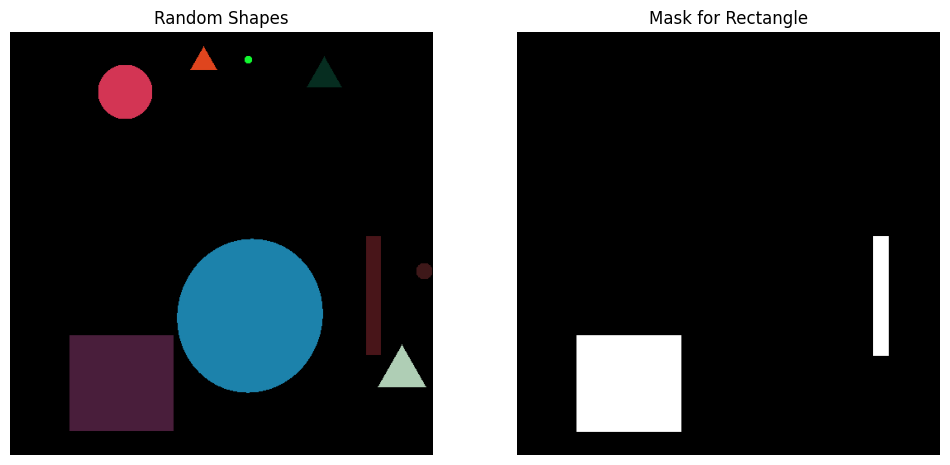

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import random_shapes, rectangle

def generate_segmentation_rect(image_size):
    image, labels = random_shapes(image_size, max_shapes=10, min_shapes=5,  allow_overlap=False)
    image = 255 - image

    mask = np.zeros(image.shape[:2], dtype=float)
    for shape, ((start_row, end_row), (start_col, end_col)) in labels:
        if shape == "rectangle":
            # print(shape, ((start_row, start_col), (end_row, end_col)) )
            rr, cc = rectangle(start=(start_row, start_col),
                                    end=(end_row, end_col),
                                    shape=image_size)
            mask[rr, cc] = 1.0

    return image, mask

image_size = (512, 512)
image, mask = generate_segmentation_rect(image_size)
print(mask.shape)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image)
ax[0].set_title('Random Shapes')
ax[0].axis('off')

ax[1].imshow(mask, cmap='gray')
ax[1].set_title('Mask for Rectangle')
ax[1].axis('off')

In [19]:
from torch import nn
import torch.optim as optim

num_classes = 2

in_channels = model.classifier[-1].in_channels
aux_in_channels = model.aux_classifier[-1].in_channels

model.classifier[-1] = nn.Conv2d(
    in_channels, num_classes, kernel_size=(1, 1), stride=(1, 1)
)
model.aux_classifier[-1] = nn.Conv2d(
    aux_in_channels, num_classes, kernel_size=(1, 1), stride=(1, 1)
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
"""
Auxiliary classifier는
중간 feature에 추가 loss를 주어
gradient 흐름을 개선하고
학습 안정성을 높이기 위한 구조다.
"""

'\nAuxiliary classifier는\n중간 feature에 추가 loss를 주어\ngradient 흐름을 개선하고\n학습 안정성을 높이기 위한 구조다.\n'

In [21]:
import torch
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

def get_batch_tensor(batch_size=8):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    images = []
    labels = []

    # Generate batch of images and labels
    for _ in range(batch_size):
        image, label = generate_segmentation_rect(image_size)

        tensor_image = TF.to_tensor(image)
        normalized_image = normalize(tensor_image)
        tensor_label = torch.from_numpy(label).long()


        images.append(normalized_image)
        labels.append(tensor_label)

    batch_images = torch.stack(images)
    batch_labels = torch.stack(labels)

    return batch_images, batch_labels

batch_images, batch_labels = get_batch_tensor(8)
print(batch_images.shape, batch_labels.shape)

torch.Size([8, 3, 512, 512]) torch.Size([8, 512, 512])


In [22]:
model.to(my_device)

model.train()
for batch_idx in range(1000):
    images, labels = get_batch_tensor(64)
    images, labels = images.to(my_device), labels.to(my_device)
    outputs = model(images)
    loss = criterion(outputs["out"], labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"batch num : {batch_idx}, loss:{loss.item()}")

model.eval()

OutOfMemoryError: CUDA out of memory. Tried to allocate 192.00 MiB. GPU 0 has a total capacity of 14.56 GiB of which 75.81 MiB is free. Including non-PyTorch memory, this process has 14.49 GiB memory in use. Of the allocated memory 14.08 GiB is allocated by PyTorch, and 291.98 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)